In [1]:
import numpy as np
import torch
from torch import nn, div, square, norm
from torch.nn import functional as F
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)

# **Preparing Data**

In [3]:
# RATINGS_PATH = 'ml-1m/ratings.dat'
# USERS_PATH = 'ml-1m/users.dat'
# ITEMS_PATH = 'ml-1m/movies.dat'
# def load_movielens_1m():
#     ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
#     ratings = pd.read_csv(RATINGS_PATH, sep='::', names=ratings_cols, engine='python', encoding='latin-1')

#     users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
#     users = pd.read_csv(USERS_PATH, sep='::', names=users_cols, engine='python', encoding='latin-1')

#     items_cols = ['item_id', 'title', 'genres']
#     items = pd.read_csv(ITEMS_PATH, sep='::', names=items_cols, engine='python', encoding='latin-1')

#     items['genres'] = items['genres'].str.split('|')
    
#     return ratings, users, items

# ratings_df, users_df, items_df = load_movielens_1m()
# num_users, num_items = users_df['user_id'].max(), items_df['item_id'].max()
# # reindex to 0-based
# users_df['user_id'] -= 1
# items_df['item_id'] -= 1
# ratings_df['user_id'] -= 1
# ratings_df['item_id'] -= 1
# users_df

In [4]:
RATINGS_PATH = 'ml-1m/ratings.dat'
USERS_PATH = 'ml-1m/users.dat'
ITEMS_PATH = 'ml-1m/movies.dat'
LINKS_PATH ='ml-1m/links.csv'
def load_movielens_1m():
    ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
    ratings = pd.read_csv(RATINGS_PATH, sep='::', names=ratings_cols, engine='python', encoding='latin-1')

    users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
    users = pd.read_csv(USERS_PATH, sep='::', names=users_cols, engine='python', encoding='latin-1')

    items_cols = ['item_id', 'title', 'genres']
    items = pd.read_csv(ITEMS_PATH, sep='::', names=items_cols, engine='python', encoding='latin-1')

    items['genres'] = items['genres'].str.split('|')
    
    links_cols = ['movieId', 'imdbId', 'tmdbId']
    links = pd.read_csv(LINKS_PATH, sep=',', names=links_cols, engine='python', encoding='latin-1')
    links = links.drop(index=0).reset_index(drop=True)
    return ratings, users, items, links

ratings_df, users_df, items_df, links_df = load_movielens_1m()
# num_users, num_items = users_df['user_id'].max(), items_df['item_id'].max()


In [5]:
items_df['item_id'] = items_df['item_id'].astype(int)
links_df['movieId'] = links_df['movieId'].astype(int)

# merge tmdbId into items_df
items_df = items_df.merge(links_df[['movieId', 'tmdbId']],
                          left_on='item_id',
                          right_on='movieId',
                          how='left')
items_df.drop(columns=['movieId'], inplace=True)

items_df['item_id'] = items_df['item_id'].astype(int)
ratings_df['item_id'] = ratings_df['item_id'].astype(int)

# Filter only rated movie in items_df
items_df = items_df[items_df['item_id'].isin(ratings_df['item_id'])].reset_index(drop=True)

old_to_new_ids = {old: new for new, old in enumerate(items_df['item_id'])}

items_df['item_id'] = items_df.index

ratings_df['item_id'] = ratings_df['item_id'].map(old_to_new_ids)

users_df['user_id'] -= 1
ratings_df['user_id'] -= 1

In [6]:
ratings_df

,user_id,item_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291
...,...,...,...,...
1000204,6039,1019,1,956716541
1000205,6039,1022,5,956704887
1000206,6039,548,5,956704746
1000207,6039,1024,4,956715648


In [7]:
items_df.to_csv('ml-1m/items.csv', index=False)
users_df.to_csv('ml-1m/users.csv', index=False)
ratings_df.to_csv('ml-1m/ratings.csv', index=False)
num_users = users_df['user_id'].max() + 1
num_items = items_df['item_id'].max() + 1
users_df 

,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455
...,...,...,...,...,...
6035,6035,F,25,15,32603
6036,6036,F,45,1,76006
6037,6037,F,56,1,14706
6038,6038,F,45,0,01060


# **Preprocessing Data**

In [8]:
for col in users_df.columns:
    print(f'{col} :{users_df[col].nunique()}')
num_users

user_id :6040
gender :2
age :7
occupation :21
zip_code :3439


np.int64(6040)

In [9]:
cols_to_encode = ['gender', 'age', 'occupation']

ordinal_encoder = OrdinalEncoder()
scaler = MinMaxScaler()

ordinal_encoded_array = ordinal_encoder.fit_transform(users_df[cols_to_encode])
scaled_array = scaler.fit_transform(ordinal_encoded_array)
scaled_df = pd.DataFrame(scaled_array, columns=cols_to_encode)
users_encoded_df = pd.concat([users_df[['user_id']], scaled_df], axis=1)

users_encoded_df

,user_id,gender,age,occupation
0,0,0.0,0.000000,0.50
1,1,1.0,1.000000,0.80
2,2,1.0,0.333333,0.75
3,3,1.0,0.666667,0.35
4,4,1.0,0.333333,1.00
...,...,...,...,...
6035,6035,0.0,0.333333,0.75
6036,6036,0.0,0.666667,0.05
6037,6037,0.0,1.000000,0.05
6038,6038,0.0,0.666667,0.00


In [10]:
train_val_users, test_users = train_test_split(torch.arange(num_users),
                                           test_size=0.1,
                                           random_state=seed)
train_users, val_users = train_test_split(train_val_users,
                                           test_size=0.1,
                                           random_state=seed)
train_users.size(), val_users.size(), test_users.size()

(torch.Size([4892]), torch.Size([544]), torch.Size([604]))

In [11]:
user_item_mat = torch.zeros((num_users, num_items))
for row in ratings_df.itertuples(index=False):
    user_id, item_id, rating, *_ = row
    user_item_mat[user_id , item_id ] = rating
user_item_mat.shape

torch.Size([6040, 3706])

In [12]:
torch.save({
    'user_item_mat': user_item_mat,
    'train_users': train_users,
    'val_users': val_users,
    'test_users': test_users
}, 'dataset_full.pt')

In [13]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, user_item_mat, user_indices):
        self.user_item_mat = user_item_mat
        self.user_indices = user_indices  # List/Tensor of user IDs

    def __len__(self):
        return len(self.user_indices)

    def __getitem__(self, idx):
        user_id = self.user_indices[idx]
        return self.user_item_mat[user_id]  # shape: [num_items]

train_dataset = MyDataset(user_item_mat, train_users)
val_dataset = MyDataset(user_item_mat, val_users)
test_dataset = MyDataset(user_item_mat, test_users)

batch_size = 256
num_workers = 2

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dl   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dl  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
# torch.save({
#     'user_item_mat': user_item_mat,
#     'train_users': train_users,
#     'val_users': val_users,
#     'test_users': test_users
# }, 'dataset.pt')

# **Model**

In [15]:
class AutoRec(nn.Module):
    def __init__(self, d, k, dropout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(d, k),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(k, d)
        )
    
    def forward(self, r):
        return self.seq(r)

In [16]:
def train_epoch(model, dl, opt, criterion, device):
    model.train()
    total_loss = 0.0
    total_samples = 0
    start_time = time.perf_counter()

    for batch_idx, r in enumerate(dl):
        r = r.to(device)

        r_hat = model(r)

        mask = torch.sign(r)  
        loss = criterion(r, r_hat * mask)

        batch_size = r.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        opt.zero_grad()
        loss.backward()
        opt.step()

    avg_loss = total_loss / total_samples
    total_time = round(time.perf_counter() - start_time, 4)
    print(f"Train done — Avg epoch loss: {avg_loss:.4f} | Total time: {total_time:.2f}s")

    return avg_loss

In [17]:
def eval_epoch(model, dl, criterion, device, log = 1):
    model.eval()
    truth = []
    predict = []
    list_loss = []
    total_weighted_loss = 0.0
    total_rated = 0
    start_time = time.perf_counter()

    with torch.no_grad():
        for batch_idx, r in enumerate(dl):
            r = r.to(device) 
            r_hat = model(r)

            mask = torch.sign(r)
            masked_pred = r_hat * mask

            truth.append(r)
            predict.append(masked_pred)

            loss = criterion(r, masked_pred)

            num_rated = mask.sum().item()

            total_weighted_loss += loss.item() * num_rated
            total_rated += num_rated

            list_loss.append(loss.item())


    avg_loss = total_weighted_loss / total_rated


    total_squared_error = 0.0
    for r_true, r_pred in zip(truth, predict):
        mask = torch.sign(r_true)
        total_squared_error += ((r_true - r_pred) ** 2 * mask).sum().item()
    rmse = np.sqrt(total_squared_error / total_rated)
    
    total_time = round(time.perf_counter() - start_time, 4)
    if(log != 0):
        print(f"Eval done | Avg loss: {avg_loss:.4f} | RMSE: {rmse:.6f} | Time: {total_time:.2f}s")

    return avg_loss, rmse


# **Training**

In [18]:
model = AutoRec(d=num_items, k=500, dropout=0.1).to(device)
# model = torch.load('autorec_full.pth', weights_only = False)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
max_epochs = 100
losses = []
val_losses = []
val_rmse = []
train_rmse = []

In [19]:
start_train_time = time.perf_counter()
for epoch in range(max_epochs):
    print("=" * 10 + f"Epoch: {epoch}" + "=" * 10)
    epoch_loss = train_epoch(model, train_dl, opt, criterion, device)
    val_loss, rmse = eval_epoch(model, val_dl, criterion, device)
    train_loss, t_rmse = eval_epoch(model, train_dl, criterion, device, log = 0)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_rmse.append(rmse)
    train_rmse.append(t_rmse)
total_train_time = round(time.perf_counter() - start_train_time, 4)
print(f'Total train time :{total_train_time:.4f}')

==========Epoch: 0==========
Train done — Avg epoch loss: 0.1879 | Total time: 2.34s
Eval done | Avg loss: 0.0757 | RMSE: 1.261978 | Time: 0.30s
==========Epoch: 1==========
Train done — Avg epoch loss: 0.0533 | Total time: 3.63s
Eval done | Avg loss: 0.0498 | RMSE: 1.024692 | Time: 0.53s
==========Epoch: 2==========
Train done — Avg epoch loss: 0.0464 | Total time: 3.54s
Eval done | Avg loss: 0.0481 | RMSE: 1.007908 | Time: 0.36s
==========Epoch: 3==========
Train done — Avg epoch loss: 0.0455 | Total time: 2.39s
Eval done | Avg loss: 0.0477 | RMSE: 1.003024 | Time: 0.34s
==========Epoch: 4==========
Train done — Avg epoch loss: 0.0450 | Total time: 2.96s
Eval done | Avg loss: 0.0474 | RMSE: 0.999901 | Time: 0.31s
==========Epoch: 5==========
Train done — Avg epoch loss: 0.0447 | Total time: 2.64s
Eval done | Avg loss: 0.0474 | RMSE: 1.000074 | Time: 0.26s
==========Epoch: 6==========
Train done — Avg epoch loss: 0.0445 | Total time: 3.63s
Eval done | Avg loss: 0.0474 | RMSE: 1.000452

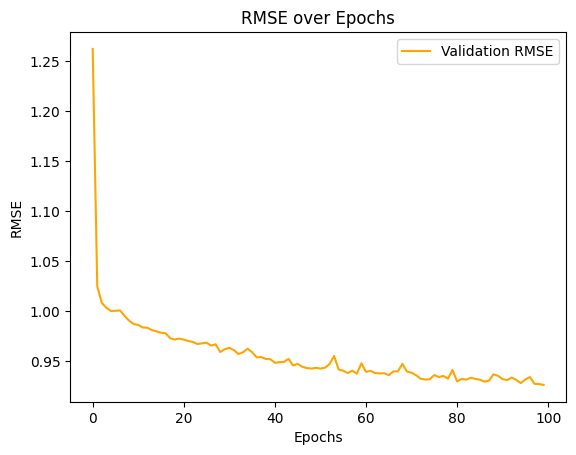

In [20]:
# plt.plot(losses)
# plt.plot(val_losses)
# plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.title("RMSE over Epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [21]:
val_loss, rmse = eval_epoch(model, test_dl, criterion, device)
print(f'Test rmse on autoencoders = {rmse}')

Eval done | Avg loss: 0.0362 | RMSE: 0.920153 | Time: 0.29s
Test rmse on autoencoders = 0.9201529777493996


In [22]:
torch.save(model, 'autorec_full.pth')

# **Combining Autoencoders with users' features**

In [23]:
def get_predicted_ratings(model, user_indices, device):
    model.eval()
    preds = []
    dataset = MyDataset(user_item_mat, user_indices)
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    with torch.no_grad():
        for r in dl:
            r = r.to(device)
            pred = model(r)
            preds.append(pred.cpu())
    return torch.cat(preds, dim=0)  
train_predicted_ratings = get_predicted_ratings(model, train_users, device)
train_predicted_ratings.shape

torch.Size([4892, 3706])

In [24]:
def get_features_df(users_df, users_indices):
    users_list = [int(i) for i in users_indices]
    filtered_users_df = users_df[users_df['user_id'].isin(users_list)]
    users_features_df = filtered_users_df.set_index('user_id').loc[users_list].reset_index()
    users_features_df = users_features_df.drop('user_id',axis = 1)
    
    return users_features_df

val_users_features_df = get_features_df(users_encoded_df, val_users)
new = val_users_features_df.drop_duplicates()
new

,gender,age,occupation
0,1.0,0.333333,0.20
1,1.0,0.166667,0.05
2,1.0,0.166667,0.20
3,1.0,0.333333,0.00
4,1.0,0.666667,0.80
...,...,...,...
508,0.0,0.666667,0.35
517,1.0,1.000000,0.55
528,0.0,0.833333,0.35
539,1.0,1.000000,1.00


In [25]:
val_truth_ratings_tensor = torch.zeros((len(val_users),num_items))
val_users_list = [int(r) for r in val_users]
for i, r in enumerate(val_users_list):
    val_truth_ratings_tensor[i] = user_item_mat[r]
    
val_users_features_tensor = torch.tensor(val_users_features_df.values, dtype=torch.float32)
val_truth_ratings_tensor.shape

torch.Size([544, 3706])

In [26]:
class UserFeaturesDataset(Dataset):
    def __init__(self, user_features, true_ratings):
        self.user_features = user_features
        self.true_ratings = true_ratings

    def __len__(self):
        return self.user_features.size(0)

    def __getitem__(self, idx):
        return {
            'features': self.user_features[idx],
            'ratings': self.true_ratings[idx],
        }
    
batch_size = 64  

dataset = UserFeaturesDataset(val_users_features_tensor, val_truth_ratings_tensor)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
class UserFeaturesNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_train_users):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_train_users) 
        )

    def forward(self, x):
        weights = self.net(x)  
        weights = F.softmax(weights, dim=1)  
        return weights

In [28]:
features_model = UserFeaturesNet(input_dim=3, hidden_dim=64, num_train_users=len(train_users))
optimizer = torch.optim.Adam(features_model.parameters(), lr=1e-3)

epochs = 50
for epoch in range(epochs):
    features_model.train()
    total_loss = 0.0
    total_rated = 0
    for batch in val_loader:
        features = batch['features']                
        r = batch['ratings']            
        mask = torch.sign(r)                        

        weights = features_model(features)         
        r_hat = torch.matmul(weights, train_predicted_ratings)  

        diff = (r_hat - r) * mask
        loss = torch.sum(diff ** 2) / torch.sum(mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        num_rated = mask.sum().item()
        total_loss += loss.item() * num_rated
        total_rated += num_rated
    print(f"Epoch {epoch + 1}/{epochs} - Avg Masked MSE: {total_loss / total_rated :.4f}")

Epoch 1/50 - Avg Masked MSE: 1.1088
Epoch 2/50 - Avg Masked MSE: 1.0957
Epoch 3/50 - Avg Masked MSE: 1.0817
Epoch 4/50 - Avg Masked MSE: 1.0678
Epoch 5/50 - Avg Masked MSE: 1.0546
Epoch 6/50 - Avg Masked MSE: 1.0420
Epoch 7/50 - Avg Masked MSE: 1.0313
Epoch 8/50 - Avg Masked MSE: 1.0218
Epoch 9/50 - Avg Masked MSE: 1.0142
Epoch 10/50 - Avg Masked MSE: 1.0091
Epoch 11/50 - Avg Masked MSE: 1.0061
Epoch 12/50 - Avg Masked MSE: 1.0036
Epoch 13/50 - Avg Masked MSE: 1.0026
Epoch 14/50 - Avg Masked MSE: 1.0017
Epoch 15/50 - Avg Masked MSE: 1.0008
Epoch 16/50 - Avg Masked MSE: 1.0001
Epoch 17/50 - Avg Masked MSE: 0.9996
Epoch 18/50 - Avg Masked MSE: 0.9988
Epoch 19/50 - Avg Masked MSE: 0.9983
Epoch 20/50 - Avg Masked MSE: 0.9976
Epoch 21/50 - Avg Masked MSE: 0.9973
Epoch 22/50 - Avg Masked MSE: 0.9962
Epoch 23/50 - Avg Masked MSE: 0.9956
Epoch 24/50 - Avg Masked MSE: 0.9947
Epoch 25/50 - Avg Masked MSE: 0.9941
Epoch 26/50 - Avg Masked MSE: 0.9935
Epoch 27/50 - Avg Masked MSE: 0.9928
Epoch 28/5

In [29]:
torch.save(features_model, 'features_net_full.pth')
total_params = sum(p.numel() for p in features_model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 318236


# **Apply on test set**`

In [30]:
test_truth_ratings_tensor = torch.zeros((len(test_users),num_items))
test_users_list = [int(r) for r in test_users]
for i, r in enumerate(test_users_list):
    test_truth_ratings_tensor[i] = user_item_mat[r]

test_users_features_df = get_features_df(users_encoded_df, test_users)
test_users_features_tensor = torch.tensor(test_users_features_df.values, dtype=torch.float32)
dataset = UserFeaturesDataset(test_users_features_tensor, test_truth_ratings_tensor)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

features_model.eval()
eval_loss = 0.0
total_rated = 0
batch_preds = []
with torch.no_grad():
    for batch in test_loader:
        features = batch['features']
        r = batch['ratings']
        mask = torch.sign(r)

        weights = features_model(features)
        r_hat = torch.matmul(weights, train_predicted_ratings)

        diff = (r_hat - r) * mask
        loss = torch.sum(diff ** 2) / torch.sum(mask)
        
        num_rated = mask.sum().item()
        eval_loss += loss.item() * num_rated
        total_rated += num_rated
        
        batch_preds.append(r_hat)

print(f"Test RMSE using Features Net: {np.sqrt(eval_loss / total_rated) :.8f}")

Test RMSE using Features Net: 0.97554292


In [31]:
preds = torch.cat(batch_preds, dim = 0)
# sample_user = 10
# topk_values, topk_indices = preds[sample_user].topk(20)
# topk_item_id = [int(k) for k in topk_indices]
# print(f'Top 20 Movies Recommended for user {sample_user} :')
# for idx, item_id in enumerate(topk_item_id):
#     title = items_df.loc[items_df['item_id'] == item_id, 'title'].values[0]
#     print(f"{idx+1}. {title}")

In [32]:
preds.shape

torch.Size([604, 3706])

In [33]:
def ndcg_at_k(predicted_indices, ground_truth_ratings_tensor, k=20):
    def dcg(relevance_scores):
        return np.sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores)])

    ground_truth_ratings = ground_truth_ratings_tensor.cpu().numpy()
    top_k_indices = [int(i) for i in predicted_indices[:k]]
    relevance = [ground_truth_ratings[i] for i in top_k_indices]

    dcg_score = dcg(relevance)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg_score = dcg(ideal_relevance)

    if idcg_score == 0:
        return 0.0
    return dcg_score / idcg_score

def mean_ndcg_at_k(test_users_list, all_preds, ground_truth_tensor, k=20):
    total_ndcg = 0.0
    num_users = len(test_users_list)

    for i, user_idx in enumerate(test_users_list):
        predicted_indices = all_preds[i]  # i là thứ tự trong test set
        ground_truth_ratings_tensor = ground_truth_tensor[i]  # tương ứng row i trong tensor
        ndcg_score = ndcg_at_k(predicted_indices, ground_truth_ratings_tensor, k)
        total_ndcg += ndcg_score

    return total_ndcg / num_users


In [34]:
_, topk_indices = torch.topk(preds, k=preds.shape[1], dim=1)  # lấy toàn bộ thứ tự item

# sorted indices of top k
all_preds_indices = topk_indices.cpu().tolist()

mean_ndcg = mean_ndcg_at_k(test_users_list, all_preds_indices, test_truth_ratings_tensor, k=20)
print(f"Mean nDCG@20: {mean_ndcg:.4f}")

Mean nDCG@20: 0.2678
